### Analysis software development 

Goal: establish smooth reading of the binary DAQ datafiles

In [1]:
import sys
sys.path.insert(0,'python/')
import struct
import matplotlib.pyplot as plt
#from scipy.stats import norm
from scipy.optimize import curve_fit


import numpy as np
# import data handling class
from DT5550 import *

In [2]:
#tcorr = np.array([0,0,-8,-11,27,49,-25,-7])
tcorr = np.zeros(N_DETECTOR)
#tcorr = np.array([0, -63,-157,-113,-237,-156, -35, -29])
#tcorr = np.array([0, -69, -202, -141, -275, -175, -19, -108])

In [3]:
def two_gamma():
    #
    # 
    #
    
    #
    # demand two valid hits
    #
    t = np.zeros(N_DETECTOR)
    tc = np.zeros(N_DETECTOR)
    if io.valid.sum() == 2:
        idet_sel = []
        #
        # get the indices of the two hits 
        #
        for idet in range(N_DETECTOR):
            if io.valid[idet]:
                idet_sel.append(idet)
        
        #
        # select events in which idet=0 detected an 1173keV gamma
        #

        
        idet_sel = np.array(idet_sel)
        
        for i in range(N_DETECTOR):
            t[i] = io.t[i]
            tc[i] = io.tc[i]
        
        Etot = io.Q.sum()
        
        if len(idet_sel) == 2 and Etot>100:
            id0 = idet_sel[0]
            id1 = idet_sel[1]
            R[id0].append(io.Q[id0]/io.ph[id0]/io.config['detector_settings'][id0]['GAIN'])
            R[id1].append(io.Q[id1]/io.ph[id1]/io.config['detector_settings'][id1]['GAIN'])

            if id0 == 0:
                delta_t[id1].append(t[id1]-t[id0])
                delta_tc[id1].append(tc[id1]-tc[id0])

        
                E0.append(io.Q[id0])
                E1.append(io.Q[id1])
        
                t0.append(t[id0])
                t1.append(t[id1])
                t0c.append(tc[id0])
                t1c.append(tc[id1])


Filename to process

Open a datafile and read the data

In [4]:
#
# open the datfile
#
io = DT5550(indir='C:/data/20220104_112605/')
    
#io = DT5550(file='../../DT5550_DAQ/daq/ReadoutClient/test0.raw')
t0 = []
t1 = []
t0c = []
t1c = []
E0 = []
E1 = []

ifile = 0

delta_t = [[] for i in range(N_DETECTOR)]
delta_tc = [[] for i in range(N_DETECTOR)]
R = [[] for i in range(N_DETECTOR)]


for file in io.filenames:
    io.open_data(file)
    while io.read_event() == 0:
        #
        #
        #
        
        if io.n_event%100000 == 0:
            print('Processed ',io.n_event,' events')
    
        # timing performance
        two_gamma()
    
t0 = np.array(t0)
t1 = np.array(t1)
t0c = np.array(t0c)
t1c = np.array(t1c)
E0 = np.array(E0)
E1 = np.array(E1)

delta_t = np.array(delta_t, dtype=object)
delta_tc = np.array(delta_tc, dtype=object)
R = np.array(R, dtype=object)


print('Processing done')

DT5550:: Data recorded with config:  C:/data/20220104_112605\config_20220104_112605.json
DT5550:: Open data file: C:/data/20220104_112605\data_20220104_112605_0.raw
Processed  100000  events
DT5550:: Open data file: C:/data/20220104_112605\data_20220104_112605_1.raw
Processed  200000  events
DT5550:: Open data file: C:/data/20220104_112605\data_20220104_112605_2.raw
Processing done


A few basic plots: integrated charge and time

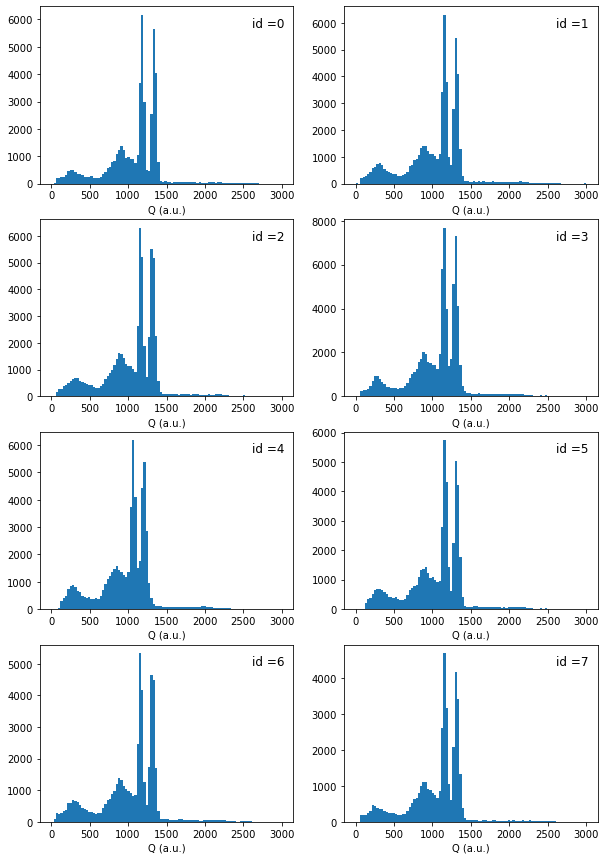

In [5]:
io.plot_all(type="charge",bins=100,logy=False, range=(0,3000))

In [6]:
# io.plot_all(type="time",range=(200,600),bins=100,logy=True)

In [7]:
# Function to be fitted
def gauss(x, x0, y0, sigma):
    p = [x0, y0, sigma]
    return p[1]* np.exp(-((x-p[0])/p[2])**2)

99.41104246240133


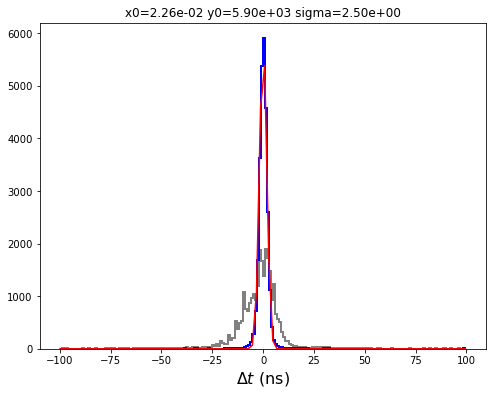

In [8]:

plt.figure(figsize=(8,6))

dtmax = 100

dt_nocorr = (t0-t1)
dt_nocorr = dt_nocorr[abs(dt_nocorr)<dtmax]

dt = (t0c-t1c)
dt = dt[abs(dt)<dtmax]

bins = 200
y, xe  = np.histogram(dt,bins=bins)
x = .5 * (xe[:-1] + xe[1:])
print(xe[-1])

# Initialization parameters
p0 = [1., 1., 1.]
# Fit the data with the function
fit, tmp = curve_fit(gauss, x, y, p0=p0)

# Plot the results
plt.title('x0=%.2e y0=%.2e sigma=%.2e' % (fit[0], fit[1], fit[2]))
# Data
plt.hist(dt_nocorr,bins=bins, histtype='step',linewidth=2,color='grey')
plt.hist(dt,bins=bins,histtype='step',linewidth=2,color='blue')

#plt.plot(x, y, drawstyle='steps', color='blue',linewidth=2)
# Fitted function
x_fine = np.linspace(xe[0], xe[-1], 100)
plt.plot(x_fine, gauss(x_fine, fit[0], fit[1], fit[2]), 'r-')

plt.xlabel('$\Delta t$ (ns)',fontsize=16)
plt.yscale('linear')
#plt.ylim(10,15000)

plt.savefig('Gaussian_fit.png')


#### calculate the time offsets

1 0.04436894436747982
2 0.03220847499497752
3 -0.027515910301801474
4 -0.11437762326104978
5 -0.005666764853059845
6 -0.038571100624786865
7 -0.06213709602077545


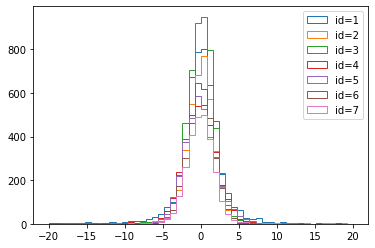

In [9]:
dtmax = 20

for i in range(1,8):
    txt = 'id='+str(i)
    h = plt.hist(delta_tc[i],bins=50,range=(-dtmax,dtmax), histtype='step', label = txt)
    dt = np.array(delta_tc[i])
    dt = dt[abs(dt)<dtmax]
    tcorr[i] = dt.mean()
    print(i,dt.mean())
plt.legend()

#### write the corrections to the json configuration

In [10]:
write = False

if write:
    for i in range(N_DETECTOR):
        toff = io.config['detector_settings'][i]['TOFF']
        io.config['detector_settings'][i]['TOFF'] = toff+1.*tcorr[i]

    fout = open(io.config_file,"w")
    json.dump(io.config, fout, indent=4)
    fout.close()

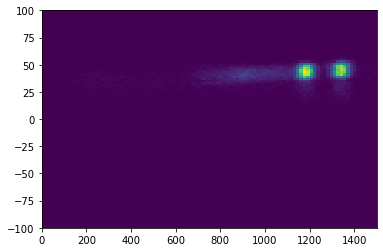

In [11]:
h = plt.hist2d(E0,t1c-440,range=((0,1500),(-100,100)),bins=(100,100))

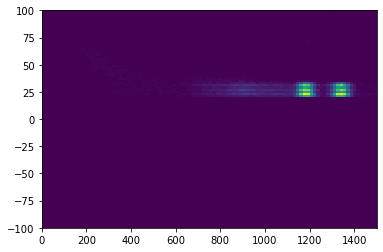

In [12]:
h = plt.hist2d(E0,t0-480,range=((0,1500),(-100,100)),bins=(100,100))

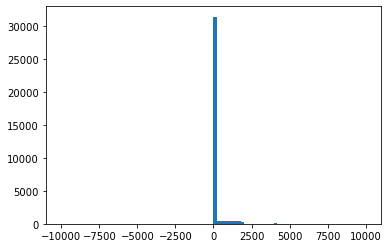

In [13]:
h = plt.hist(t0-480,range=(-10000,10000),bins=100)

(array([3.0865e+04, 1.2760e+03, 9.9300e+02, 9.7800e+02, 7.0400e+02,
        1.0000e+00, 2.0000e+00, 5.0000e+00, 2.0000e+01, 1.2000e+02]),
 array([-2.05265017e+00,  4.99039446e+02,  1.00013154e+03,  1.50122364e+03,
         2.00231574e+03,  2.50340783e+03,  3.00449993e+03,  3.50559202e+03,
         4.00668412e+03,  4.50777622e+03,  5.00886831e+03]),
 <BarContainer object of 10 artists>)

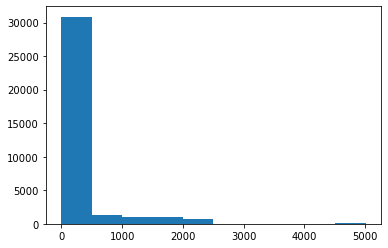

In [14]:
plt.hist(t0c)

0  <R> = 0.000820760415768341
1  <R> = 0.0007984633936253344
2  <R> = 0.0007998044218251126
3  <R> = 0.0008033760761381012
4  <R> = 0.0008105683513678083
5  <R> = 0.0008454800823685295
6  <R> = 0.0007965572070693783
7  <R> = 0.0007942284921859808


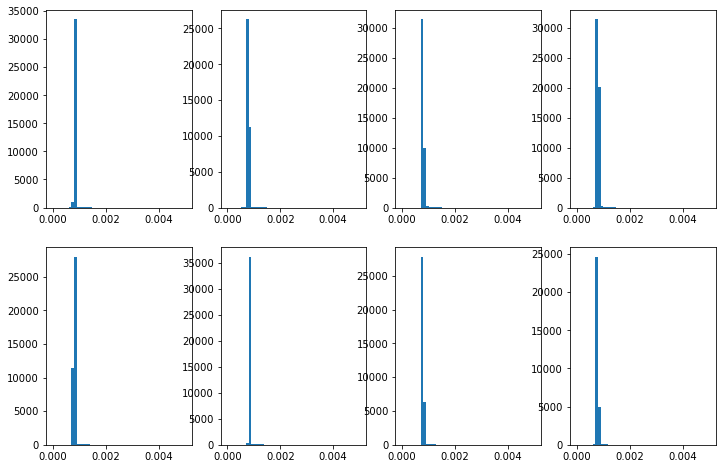

In [15]:
plt.figure(figsize=(12,8))

for i in range(8):
    plt.subplot(2,4,1+i)
    h= plt.hist(R[i],bins=50,range=(0,0.005))
    print(i,' <R> =',np.mean(R[i]))
    plt.yscale('linear')